In [1]:
try:
    import linearmodels
except ModuleNotFoundError:
    ! pip install linearmodels
    import linearmodels

In [2]:
try:
    import plottable
except ModuleNotFoundError:
    ! pip install plottable
    import plottable

In [4]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point
from scipy import stats
from scipy.stats import gaussian_kde
import contextily as ctx
import matplotlib.gridspec as gridspec
import matplotlib.colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statsmodels.api as sm
from linearmodels import RandomEffects
from sklearn.preprocessing import MinMaxScaler
from plottable import Table
import warnings
warnings.filterwarnings("ignore")

In [5]:
# set year list
year_list = ['2019', '2020', '2021', '2022', '2023']

# original file
url = ["https://github.com/cabbagejiejiejie/fsds-group-work/blob/main/data/drop_cols_listings-2019.csv?raw=true",
       "https://github.com/cabbagejiejiejie/fsds-group-work/blob/main/data/drop_cols_listings-2020.csv?raw=true",
       "https://github.com/cabbagejiejiejie/fsds-group-work/blob/main/data/drop_cols_listings-2021.csv?raw=true",
       "https://github.com/cabbagejiejiejie/fsds-group-work/blob/main/data/drop_cols_listings-2022.csv?raw=true",
       "https://github.com/cabbagejiejiejie/fsds-group-work/blob/main/data/drop_cols_listings-2023.csv?raw=true"]

# read in original airbnb data
df_2019 = pd.read_csv(url[0], low_memory=False)
df_2020 = pd.read_csv(url[1], low_memory=False)
df_2021 = pd.read_csv(url[2], low_memory=False)
df_2022 = pd.read_csv(url[3], low_memory=False)
df_2023 = pd.read_csv(url[4], low_memory=False)

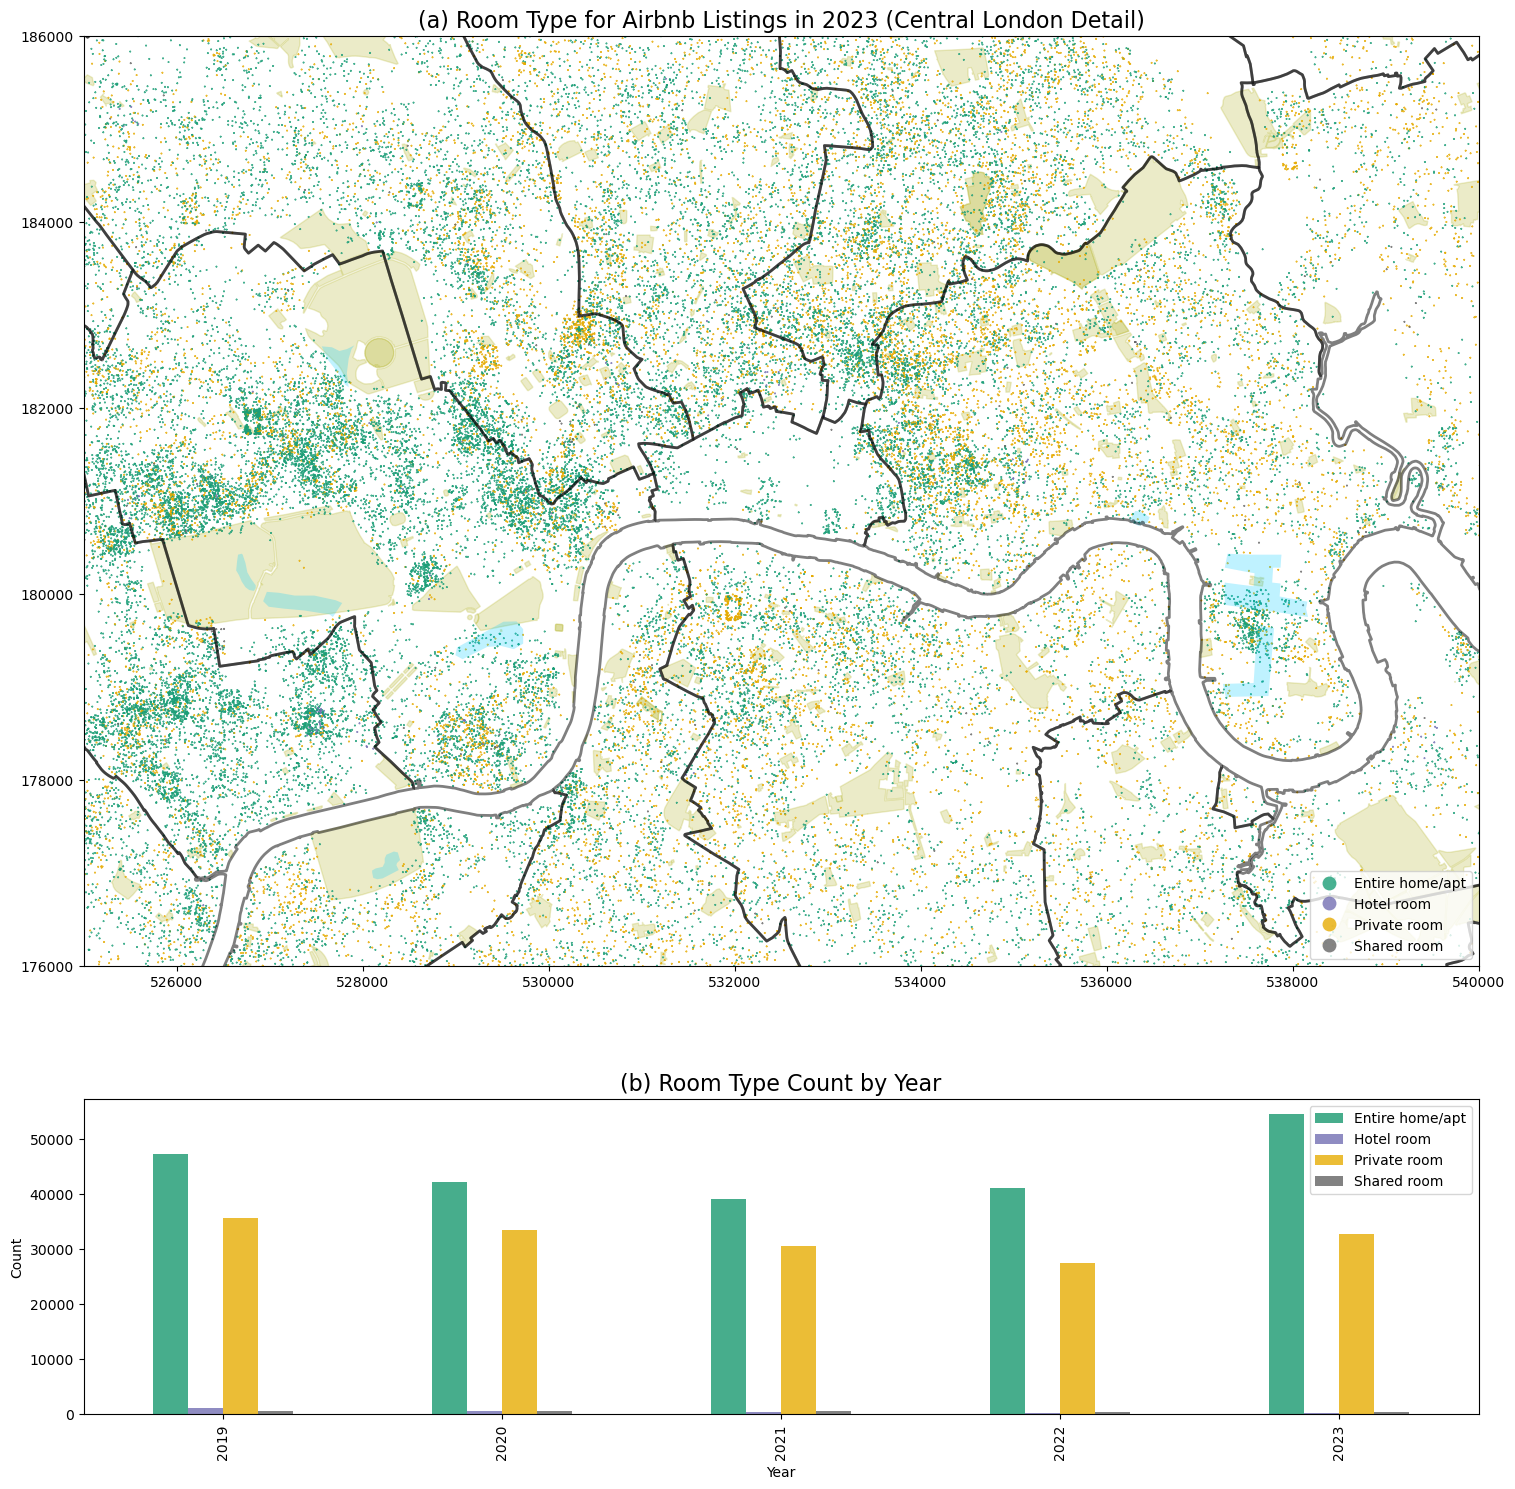

In [6]:
# plot room type

# set data frame of room type in 2023
df_room_type_2023 = df_2023

# transform df_room_type to gpd
gdf_room_type = gpd.GeoDataFrame(df_room_type_2023, 
      geometry=gpd.points_from_xy(df_room_type_2023.longitude, df_room_type_2023.latitude, crs='epsg:4326'))

# transform crs of gdf_room_type from 4326 to 27700
gdf_room_type = gdf_room_type.to_crs(27700)

# read in London Borough Green Water
london_borough_path = 'https://github.com/cabbagejiejiejie/fsds-group-work/blob/main/data/London-borough/Boroughs.gpkg?raw=true'
london_water_path = 'https://github.com/cabbagejiejiejie/fsds-group-work/blob/main/data/London-borough/Water.gpkg?raw=true'
london_green_path = 'https://github.com/cabbagejiejiejie/fsds-group-work/blob/main/data/London-borough/Greenspace.gpkg?raw=true'

boros = gpd.read_file(london_borough_path)
water = gpd.read_file(london_water_path)
green = gpd.read_file(london_green_path)

# merge room type data of 5 years into one data frame
# 2023
df_room_type_2023 = df_2023
df_room_type_counts_2023 = df_room_type_2023['room_type'].value_counts().reset_index()
df_room_type_counts_2023['year'] = 2023
df_room_type_counts_2023['index'] = [0, 2, 3, 1]
df_room_type_counts_2023.set_index('index', inplace=True)
df_room_type_counts_2023 = df_room_type_counts_2023.sort_index()

# 2022
df_room_type_2022 = df_2022
df_room_type_counts_2022 = df_room_type_2022['room_type'].value_counts().reset_index()
df_room_type_counts_2022['year'] = 2022
df_room_type_counts_2022['index'] = [0, 2, 3, 1]
df_room_type_counts_2022.set_index('index', inplace=True)
df_room_type_counts_2022 = df_room_type_counts_2022.sort_index()

# 2021
df_room_type_2021 = df_2021
df_room_type_counts_2021 = df_room_type_2021['room_type'].value_counts().reset_index()
df_room_type_counts_2021['year'] = 2021
df_room_type_counts_2021['index'] = [0, 2, 3, 1]
df_room_type_counts_2021.set_index('index', inplace=True)
df_room_type_counts_2021 = df_room_type_counts_2021.sort_index()

# 2020
df_room_type_2020 = df_2020
df_room_type_counts_2020 = df_room_type_2020['room_type'].value_counts().reset_index()
df_room_type_counts_2020['year'] = 2020
df_room_type_counts_2020['index'] = [0, 2, 3, 1]
df_room_type_counts_2020.set_index('index', inplace=True)
df_room_type_counts_2020 = df_room_type_counts_2020.sort_index()

# 2019
df_room_type_2019 = df_2019
df_room_type_counts_2019 = df_room_type_2019['room_type'].value_counts().reset_index()
df_room_type_counts_2019['year'] = 2019
df_room_type_counts_2019 = df_room_type_counts_2019.drop(df_room_type_counts_2019.index[-1])
df_room_type_counts_2019['index'] = [0, 2, 1, 3]
df_room_type_counts_2019.set_index('index', inplace=True)
df_room_type_counts_2019 = df_room_type_counts_2019.sort_index()

# merge five years into one data frame
df_room_type_counts = pd.DataFrame()

for i in [df_room_type_counts_2019, df_room_type_counts_2020, df_room_type_counts_2021,
         df_room_type_counts_2022, df_room_type_counts_2023]:
    df_room_type_counts = pd.concat([df_room_type_counts, i], ignore_index=True)

# output
# set figure size
fig = plt.figure(figsize=(18, 18))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14, 0.25), zorder=1, ax=ax1)
water.plot(edgecolor="none", facecolor=(0, 0.8, 1, 0.25), zorder=2, ax=ax1)
boros.plot(edgecolor=(0, 0, 0, 0.5), facecolor='none', linewidth=2, zorder=3, ax=ax1)

ax1.set_xlim([525000,540000])
ax1.set_ylim([176000,186000])

# ax.axis('off') # Don't plot the axes

gdf_room_type.plot(marker='*', markersize=0.25, column='room_type', cmap='Dark2', 
         legend=True, alpha = 0.8, ax = ax1)
ax1.set_title("(a) Room Type for Airbnb Listings in 2023 (Central London Detail)", fontsize = 16)

# grouping the data of df_room_type_counts
grouped = df_room_type_counts.groupby(['year', 'room_type']).sum().unstack()

# bar plot
colors = {"Entire home/apt": (0.28, 0.68, 0.55, 1), "Hotel room": (0.56, 0.55, 0.76, 1),
          "Private room": (0.92, 0.74, 0.21, 1), "Shared room": (0.51, 0.51, 0.51, 1)}
grouped.plot(kind='bar', color=[colors[name] for name in grouped.columns.levels[1]], ax=ax2)

# add title and label
ax2.set_title("(b) Room Type Count by Year", fontsize = 16)
ax2.set_xlabel("Year", fontsize = 10)
ax2.set_ylabel("Count", fontsize = 10)
ax2.legend([name for name in grouped.columns.levels[1]])

# plt.savefig('output_image.png')

In [7]:
# load airbnb
df_airbnb_KDE = df_2023

# Add a column of geometry based on latitude and longitude
df_airbnb_KDE['geometry'] = df_airbnb_KDE.apply(lambda x: Point((float(x.longitude), float(x.latitude))), axis=1)

# Converting df_airbnb_KDE to geopanda files
gdf_airbnb_KDE = gpd.GeoDataFrame(df_airbnb_KDE, geometry='geometry', crs = 'EPSG:4326')

# converting GeoDataFrames and London boroughs to Web Mercator Projections
gdf_airbnb_KDE = gdf_airbnb_KDE.to_crs(epsg=3857)
boros = boros.to_crs(epsg=3857)

# calculate KDE
longitude = gdf_airbnb_KDE.geometry.x
latitude = gdf_airbnb_KDE.geometry.y

xy = np.vstack([longitude, latitude])
kde = gaussian_kde(xy, bw_method= 'silverman') # bw_method='scott' bw_method='silverman' bw_method=0.1

grid_x, grid_y = np.mgrid[longitude.min():longitude.max():200j, latitude.min():latitude.max():200j]
grid_coords = np.vstack([grid_x.ravel(), grid_y.ravel()])
z = kde(grid_coords).reshape(grid_x.shape)

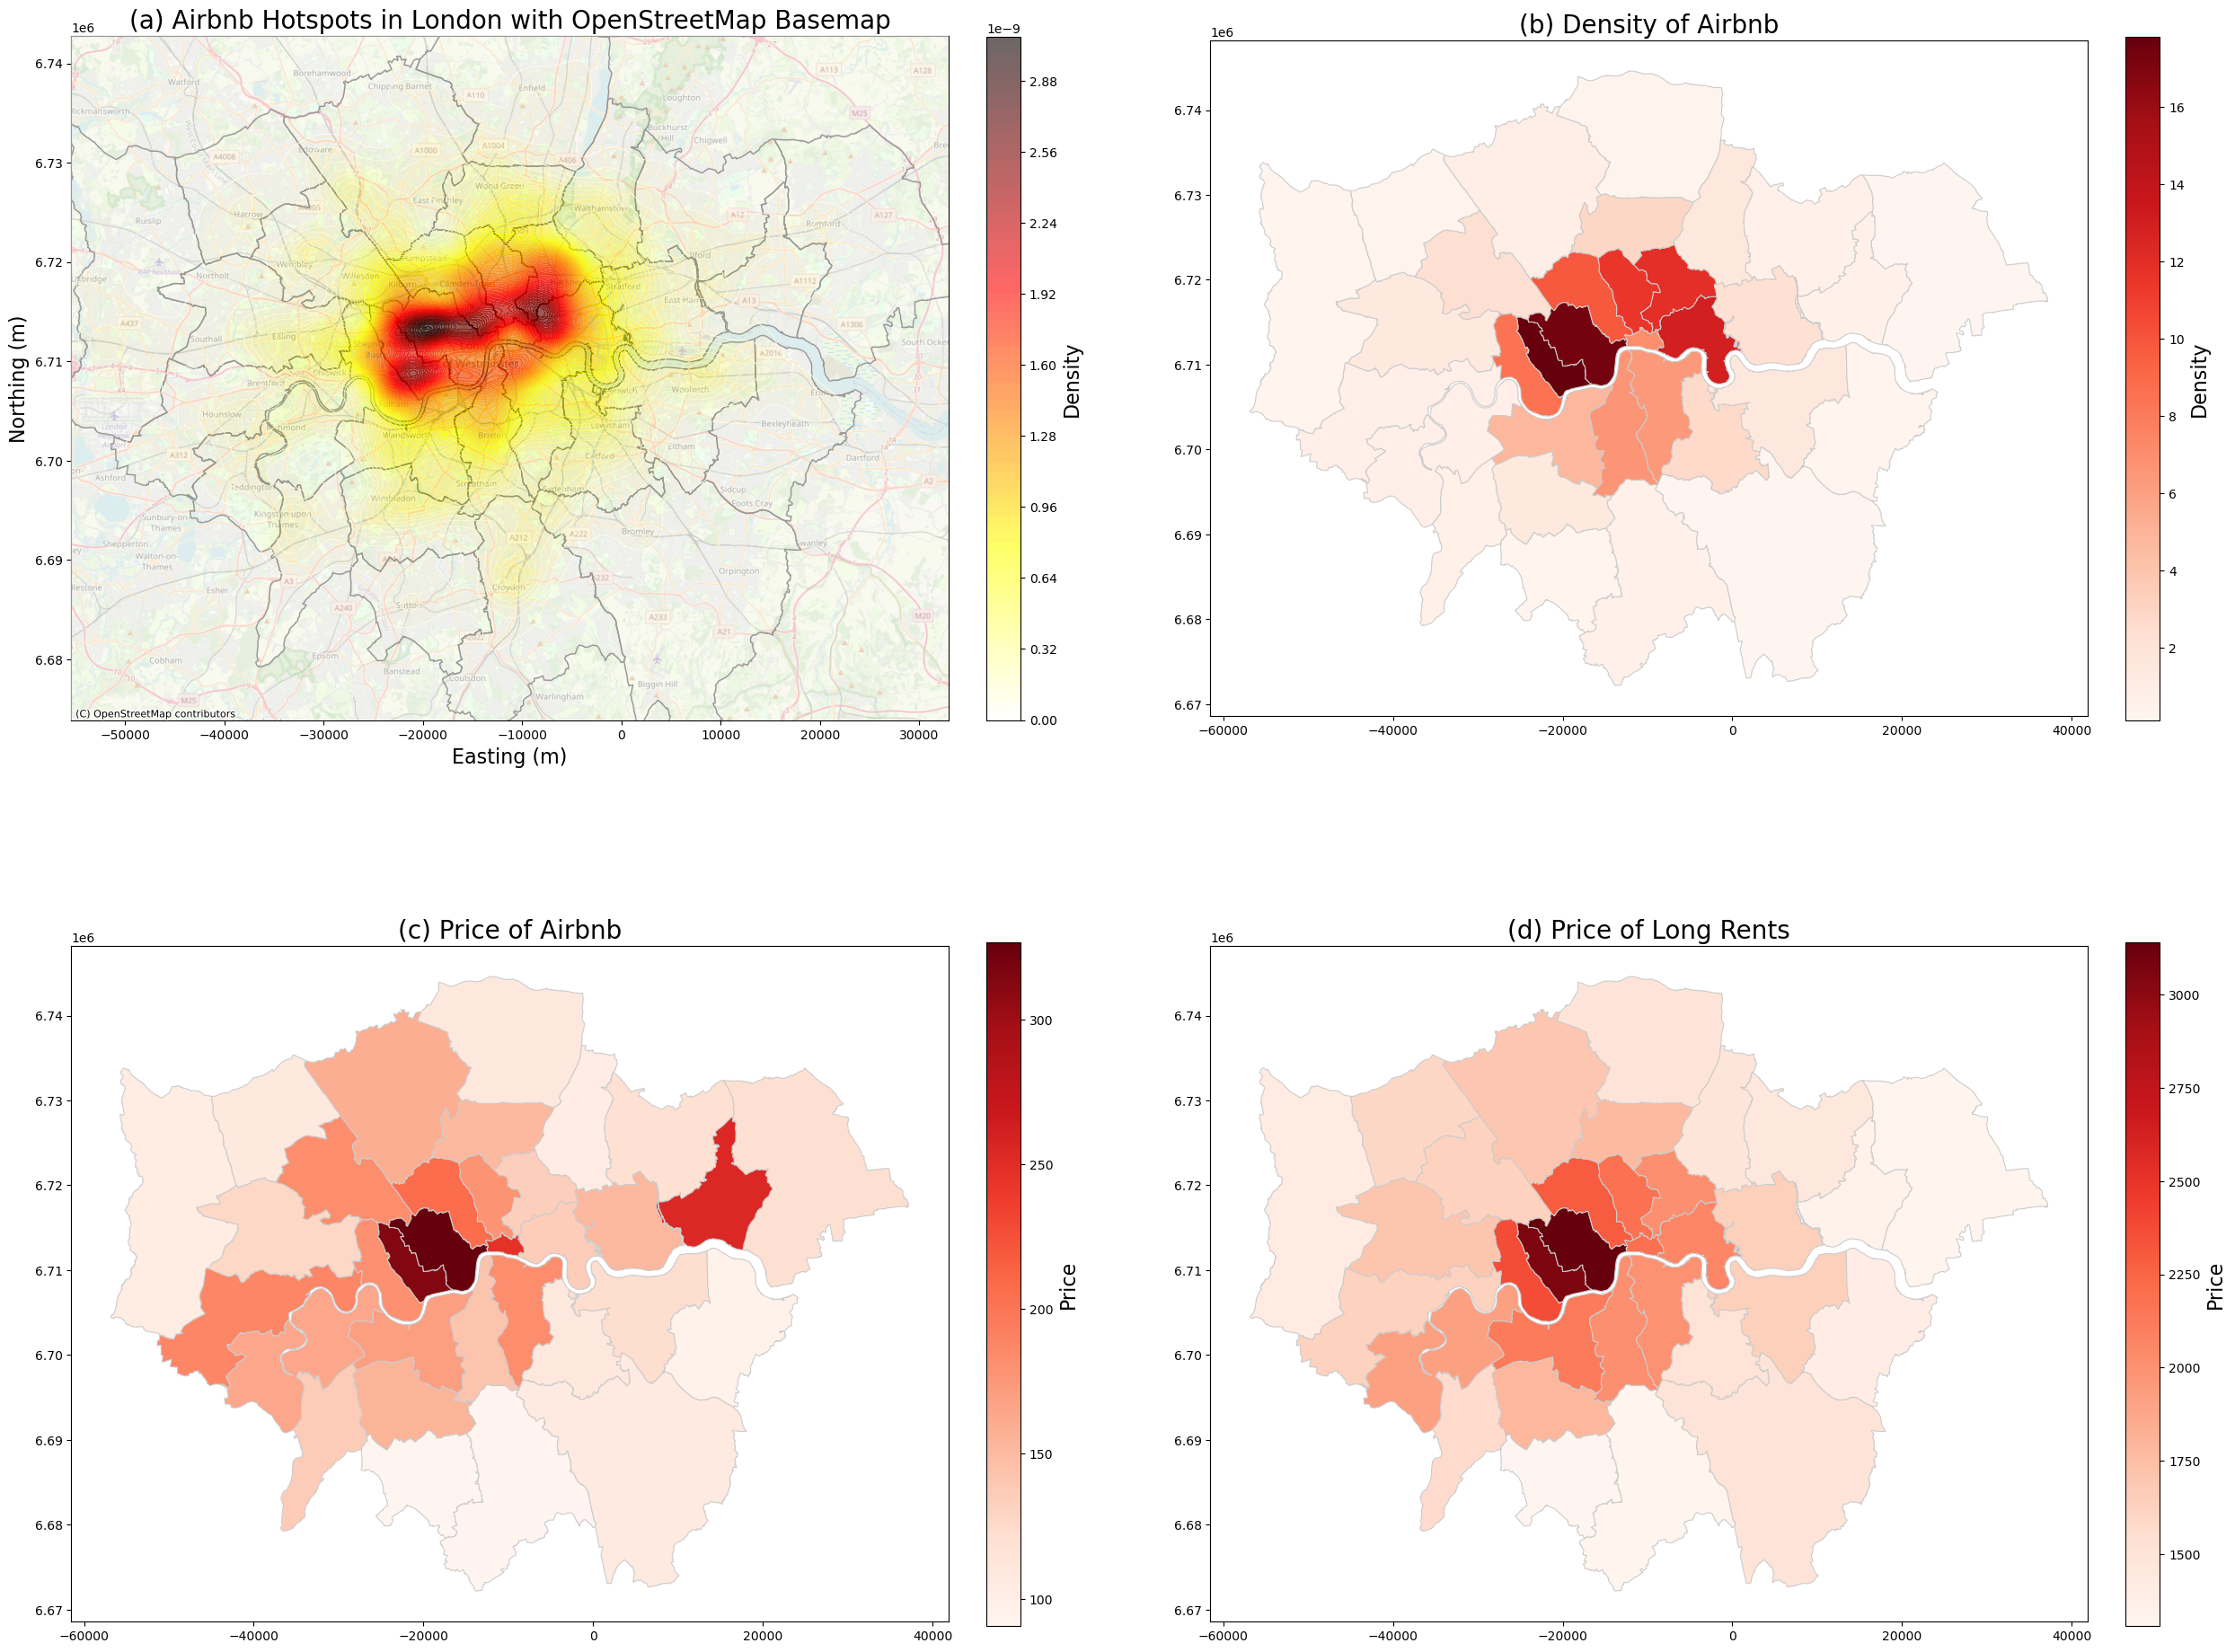

In [9]:
# set empty data frame to store airbnb data
df_airbnb_borough_2019 = pd.DataFrame()
df_airbnb_borough_2020 = pd.DataFrame()
df_airbnb_borough_2021 = pd.DataFrame()
df_airbnb_borough_2022 = pd.DataFrame()
df_airbnb_borough_2023 = pd.DataFrame()

list_of_airbnb_df = [df_airbnb_borough_2019, df_airbnb_borough_2020, df_airbnb_borough_2021,
                    df_airbnb_borough_2022, df_airbnb_borough_2023]


gdf = boros
# Calculate the area of each area (in square metres)
gdf['borough_area'] = gdf.geometry.area

gdf_1 = gdf[['NAME', 'borough_area']]

# data celaning, prepare panel data
for year in range(0, len(year_list)):
    df = pd.read_csv(url[year], low_memory=False) # compression='gzip'
    
    if year_list[year] == '2019':
    
        df = df[df['availability_365'] != ' ']
        df['availability_365'].astype(int)
        df = df[df['availability_365'] != 0]
        
        df.drop(df[df['price'] == ' '].index, inplace=True)
        df['price'] = df['price'].astype('float')
        
        df_new = df.groupby('neighbourhood').agg({'neighbourhood': 'count', 'price': 'mean'}).rename(columns={'neighbourhood': 'region'})
        df_new.reset_index(inplace=True)
        df_new.columns = ['borough', 'count_airbnb', 'price_airbnb']
        
        df_new['year'] = year_list[year]

        merged_df = pd.merge(df_new, gdf_1, left_on='borough', right_on='NAME', how='left')
        #merged_df.head()
        merged_df = merged_df.drop('NAME', axis=1)

        merged_df['density_airbnb'] = merged_df['count_airbnb'] / merged_df['borough_area'] * 100000
        #merged_df.head()
        merged_df['code'] = pd.factorize(merged_df['borough'])[0] + 1
        #merged_df.head()
    
    else:
        
        df = df[df['has_availability'] != 'f']

        df.drop(df[df['price'] == ' '].index, inplace=True)
        df['price'] = df['price'].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')
        
        df_new = df.groupby('neighbourhood_cleansed').agg({'neighbourhood_cleansed': 'count', 'price': 'mean'}).rename(columns={'neighbourhood_cleansed': 'region'})
        df_new.reset_index(inplace=True)
        df_new.columns = ['borough', 'count_airbnb', 'price_airbnb']
        
        df_new['year'] = year_list[year]

        merged_df = pd.merge(df_new, gdf_1, left_on='borough', right_on='NAME', how='left')
        #merged_df.head()
        merged_df = merged_df.drop('NAME', axis=1)

        merged_df['density_airbnb'] = merged_df['count_airbnb'] / merged_df['borough_area'] * 100000
        #merged_df.head()
        merged_df['code'] = pd.factorize(merged_df['borough'])[0] + 1
        #merged_df.head()
    
    list_of_airbnb_df[year] = merged_df

df_airbnb_borough_2019 = list_of_airbnb_df[0]
df_airbnb_borough_2020 = list_of_airbnb_df[1]
df_airbnb_borough_2021 = list_of_airbnb_df[2]
df_airbnb_borough_2022 = list_of_airbnb_df[3]
df_airbnb_borough_2023 = list_of_airbnb_df[4]


# Merge airbnb data
df_airbnb_borough = pd.DataFrame()

for i in [df_airbnb_borough_2019, df_airbnb_borough_2020, df_airbnb_borough_2021,
         df_airbnb_borough_2022, df_airbnb_borough_2023]:
    df_airbnb_borough = pd.concat([df_airbnb_borough, i], ignore_index=True)


# set empty data frame to store rental data
df_rental_borough_2019 = pd.DataFrame()
df_rental_borough_2020 = pd.DataFrame()
df_rental_borough_2021 = pd.DataFrame()
df_rental_borough_2022 = pd.DataFrame()
df_rental_borough_2023 = pd.DataFrame()

sheet_name = 'Table 1.2'

list_of_rental_df = [df_rental_borough_2019, df_rental_borough_2020, df_rental_borough_2021,
                    df_rental_borough_2022, df_rental_borough_2023]

# wrangling rental data
url_rental = ["https://github.com/cabbagejiejiejie/fsds-group-work/blob/main/data/london_rental_2019.xls?raw=true",
       "https://github.com/cabbagejiejiejie/fsds-group-work/blob/main/data/london_rental_2020.xls?raw=true",
       "https://github.com/cabbagejiejiejie/fsds-group-work/blob/main/data/london_rental_2021.xls?raw=true",
       "https://github.com/cabbagejiejiejie/fsds-group-work/blob/main/data/london_rental_2022.xls?raw=true",
       "https://github.com/cabbagejiejiejie/fsds-group-work/blob/main/data/london_rental_2023.xls?raw=true"]

# data celaning, prepare rental data
for year in range(0, len(year_list)):
    
    # 读取 Excel文件中的特定工作表
    data = pd.read_excel(url_rental[year], sheet_name=sheet_name,skiprows=12,header=0)
    specific_data = data.iloc[:198, 1:5]
    # 选择数据
    data_select = specific_data[['Borough','Count of rents','Mean']]
    data_select.rename(columns={'Count of rents': 'count_long_rents'}, inplace=True)
    # 将数据转换为数字型，去除无法转换数据
    for i in ['count_long_rents','Mean'] :
        data_select[i] = pd.to_numeric(data_select[i], errors='coerce')
        data_select = data_select.dropna(subset=[i])
     
    data_select['count_long_rents']= data_select['count_long_rents'].astype(int)
    
    data_select['TotalPrice'] = data_select['count_long_rents'] * data_select['Mean']
    
    sum_by_borough = data_select.groupby('Borough').sum()
    
    sum_by_borough['price_long_rents'] = sum_by_borough['TotalPrice'] / sum_by_borough['count_long_rents']
    sum_by_borough['Year'] = year_list[year]
    sum_by_borough['Area'] = sum_by_borough.index

    list_of_rental_df[year] = sum_by_borough

df_rental_borough_2019 = list_of_rental_df[0]
df_rental_borough_2020 = list_of_rental_df[1]
df_rental_borough_2021 = list_of_rental_df[2]
df_rental_borough_2022 = list_of_rental_df[3]
df_rental_borough_2023 = list_of_rental_df[4]


# Merge rental data
df_rental_borough = pd.DataFrame()

for i in [df_rental_borough_2019, df_rental_borough_2020, df_rental_borough_2021,
         df_rental_borough_2022, df_rental_borough_2023]:
    df_rental_borough = pd.concat([df_rental_borough, i], ignore_index=True)


df_1 = df_airbnb_borough
df_2 = df_rental_borough

merged_airbnb_rental = pd.merge(df_1, df_2, left_on=['borough', 'year'], right_on=['Area', 'Year'], how='left')

merged_airbnb_rental = merged_airbnb_rental.drop(['Mean', 'TotalPrice', 'Year', 'Area'], axis = 1)

# Screening 2023 data
df_merged_2023 = merged_airbnb_rental[merged_airbnb_rental['year'] == '2023']

# set London borough
gdf_london_borough_plot = boros

# join merged_airbnb_rental with london borough
merged_gdf_2023 = gdf_london_borough_plot.set_index('NAME').join(df_merged_2023.set_index('borough'), how='inner', lsuffix='_left', rsuffix='_right').reset_index()



# prepare for KDE
# load airbnb
df_airbnb_KDE = df_2023

# Add a column of geometry based on latitude and longitude
df_airbnb_KDE['geometry'] = df_airbnb_KDE.apply(lambda x: Point((float(x.longitude), float(x.latitude))), axis=1)

# Converting df_airbnb_KDE to geopanda files
gdf_airbnb_KDE = gpd.GeoDataFrame(df_airbnb_KDE, geometry='geometry', crs = 'EPSG:4326')

# converting GeoDataFrames and London boroughs to Web Mercator Projections
gdf_airbnb_KDE = gdf_airbnb_KDE.to_crs(epsg=3857)
boros = boros.to_crs(epsg=3857)

# calculate KDE
longitude = gdf_airbnb_KDE.geometry.x
latitude = gdf_airbnb_KDE.geometry.y

xy = np.vstack([longitude, latitude])
kde = gaussian_kde(xy, bw_method= 'silverman') # bw_method='scott' bw_method='silverman' bw_method=0.1

grid_x, grid_y = np.mgrid[longitude.min():longitude.max():200j, latitude.min():latitude.max():200j]
grid_coords = np.vstack([grid_x.ravel(), grid_y.ravel()])
z = kde(grid_coords).reshape(grid_x.shape)

# plot
# Screening 2023 data
df_merged_2023 = merged_airbnb_rental[merged_airbnb_rental['year'] == '2023']

# set London borough
gdf_london_borough_plot = boros

# join merged_airbnb_rental with london borough
merged_gdf_2023 = gdf_london_borough_plot.set_index('NAME').join(df_merged_2023.set_index('borough'), how='inner', lsuffix='_left', rsuffix='_right').reset_index()

colormap = 'Reds'

# Create four subgraphs
fig, ax = plt.subplots(2, 2, figsize=(30, 24))

# plot KDE
# plot London borough
boros.plot(ax=ax[0,0], color='none', edgecolor='black', zorder=2)

# plot kernel density layers
cf = ax[0,0].contourf(grid_x, grid_y, z, levels=100, cmap=plt.cm.hot_r, alpha=0.6, zorder=3)

# plot OpenStreetMap 
ctx.add_basemap(ax[0,0], source=ctx.providers.OpenStreetMap.Mapnik, zorder=1)

# adjusting the axes to fit the drawing
ax[0,0].set_xlim(longitude.min(), longitude.max())
ax[0,0].set_ylim(latitude.min(), latitude.max())

# add a colour bar
cbar = plt.colorbar(cf, ax=ax[0,0], orientation='vertical', fraction=0.036, pad=0.04)
cbar.set_label('Density', fontsize = 16)

# set x,y axis
ax[0,0].set_xlabel('Easting (m)', fontsize = 16)
ax[0,0].set_ylabel('Northing (m)', fontsize = 16)

# set title
ax[0,0].set_title('(a) Airbnb Hotspots in London with OpenStreetMap Basemap', fontsize = 20)



merged_gdf_2023.plot(column='density_airbnb', cmap=colormap, linewidth=0.8, ax=ax[0,1], edgecolor='0.8')
ax[0,1].set_title('(b) Density of Airbnb', fontsize = 20)
vmin = merged_gdf_2023['density_airbnb'].min()
vmax = merged_gdf_2023['density_airbnb'].max()
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm._A = []
cbar = plt.colorbar(sm, ax=ax[0,1], orientation='vertical', fraction=0.036, pad=0.04)
cbar.set_label('Density', fontsize = 16)


merged_gdf_2023.plot(column='price_airbnb', cmap=colormap, linewidth=0.8, ax=ax[1,0], edgecolor='0.8')
ax[1,0].set_title('(c) Price of Airbnb', fontsize = 20)
vmin = merged_gdf_2023['price_airbnb'].min()
vmax = merged_gdf_2023['price_airbnb'].max()
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm._A = []
cbar = plt.colorbar(sm, ax=ax[1,0], orientation='vertical', fraction=0.036, pad=0.04)
cbar.set_label('Price', fontsize = 16)

merged_gdf_2023.plot(column='price_long_rents', cmap=colormap, linewidth=0.8, ax=ax[1,1], edgecolor='0.8')
ax[1,1].set_title('(d) Price of Long Rents', fontsize = 20)
vmin = merged_gdf_2023['price_long_rents'].min()
vmax = merged_gdf_2023['price_long_rents'].max()
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm._A = []
cbar = plt.colorbar(sm, ax=ax[1,1], orientation='vertical', fraction=0.036, pad=0.04)
cbar.set_label('Price', fontsize = 16)

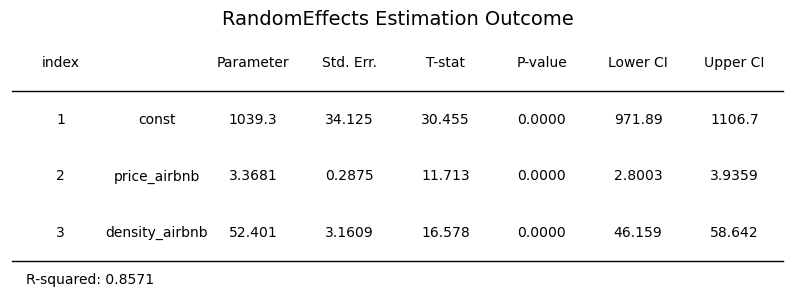

In [10]:
import statsmodels.api as sm

panel_data = merged_airbnb_rental

panel_data[['price_airbnb', 'density_airbnb', 'price_long_rents']] = panel_data[['price_airbnb', 'density_airbnb', 'price_long_rents']].round(3)

panel_data['index_column'] = panel_data.index

panel_data = panel_data.set_index(["year", "code"])

# Selection of independent and dependent variables
independent_vars = [
    "price_airbnb",
    "density_airbnb",
]
dependent_var = "price_long_rents"  # Previously calculated composite index

# Preparing the dependent and independent variables for the model
Y = panel_data[dependent_var]
X = panel_data[independent_vars]

# Adding a constant term
X = sm.add_constant(X)

# Constructing a random effects model
model = RandomEffects(Y, X)
results = model.fit()

# Extraction factors and statistics
coefficients_df = pd.DataFrame(results.summary.tables[1])
coefficients_df.columns = coefficients_df.iloc[0]  # First row as column name
coefficients_df = coefficients_df.drop(0)          # Delete column name rows

# Extract R-squared values
r_squared = results.rsquared

# Output the final DataFrame
coefficients_df

# plot
fig, ax = plt.subplots(figsize=(10, 3))
Table(
    coefficients_df,
    textprops = {
        'fontsize': 10,
        'ha':'center'
    },
    col_label_divider = True,
    footer_divider = True,
    row_dividers=False 
)
ax.set_title('RandomEffects Estimation Outcome', fontsize = 14)

# Add text in the bottom left corner of the figure
ax.text(0.02, -0.1, 'R-squared: 0.8571',
        transform=ax.transAxes,  # Use axis coordinates, so (0,0) is bottom left and (1,1) is top right
        fontsize=10,
        ha='left',  # Horizontal alignment
        va='bottom')  # Vertical alignment

plt.show()